## Comic Book Covers
### Image & Metadata Exploratory Analysis

This notebook contains an exploratory data analysis of comic book images and metadata scraped from https://comics.org. 

The methods created for this analysis come w/ tests and docstrings that can be found in the `comics_net.webscraper` and `comics_net.analyzer` modules.

In [2]:
import math
import operator
import os
import random
import re
from functools import reduce

import jsonlines
import numpy as np
import pandas as pd
from IPython.display import clear_output, display
from pandas import DataFrame
from PIL import Image

from comics_net import analyzer
from comics_net.character_map import aliases
from comics_net.webscraper import strip_brackets

In [3]:
# load the metadata
df = analyzer.load_metadata('../metadata/covers.jsonl')

# parse issue number and cast as int
df['issue_number'] = df['title'].apply(analyzer.get_issue_number_from_title)

# describe categorical metadata features
df.drop(['issue_number', 'covers'], axis=1).describe().T

,count,unique,top,freq
format_binding,95364,185,Saddle-stitched,36304
format_color,95364,117,Color,47425
format_dimensions,95364,395,standard Modern Age US,18403
format_paper_stock,95364,329,,23219
format_publishing_format,95364,149,was ongoing series,34284
indexer_notes,95364,53594,,23530
indicia_frequency,95364,2031,monthly,35222
issue_brand,95364,387,DC [bullet],12958
issue_indicia_publisher,95364,206,DC Comics,18521
issue_pages,95364,326,36,61558


Above we show the sumamry statistics of the issue metadata for the comic books scraped thus far. 

This summary only contains the _issue_ metadata and does not include the _cover_ metadata, which is specific to the image of the comic book cover. Because there are variant covers this information is stored as `dicts` in the "covers" field.

## Unpack Covers & Parse Character Labels

Since some issues contain variant covers drawn by different artists and containing different characters on them, each comic book contains issue metadata and cover-image metadata

Below we unpack the covers metadata and parse the list of characters appearing on each cover (and variant).

In [4]:
# create cover df
covers_dict = df["covers"].to_dict()

# add dataframe index to cover image-level metadata
for d1 in covers_dict:
    for d2 in covers_dict[d1]:
        covers_dict[d1][d2]["index"] = d1
        
# unpack cover image-level metadata
df_covers = pd.concat([pd.DataFrame(x).T for x in covers_dict.values()], axis=0)

# join cover-image-level metadata back with issues metadata
df = pd.merge(df.reset_index(),
              df_covers,
              how='outer',
              on='index').\
    sort_values(["series_name", "issue_number"], ascending=True).\
    drop(["index", "covers"], axis=1).\
    reset_index(drop=True).\
    copy()

# convert cover_characters string to list
def map_convert_characters_to_list(characters: str):
    if characters is np.nan:
        return np.nan
    else:
        return analyzer.convert_characters_to_list(characters)

# listify character string
df["cover_characters_list"] = df["cover_characters"].apply(map_convert_characters_to_list)

## Pre-process Character Labels

The comic book cover cover images and character label data scraped from https://comics.org may contain slight variations in a character label, for example, Superman may be labeled as:
```
[
"Superman [Clark Kent/ Kal-El]",
"Superman [Clark Kent]"
"Superman [Kal-El]"
"Superman (Earth-1)"
"Superman (of Earth-1)"
"Superman (Earth One)"
"Superman (Earth-2)"
"Superman (of Earth-2)"
"Superman [Kal Kent/ Kal-El]"
]
```
But for the classification and style transfer tasks we will perform, these labels are equivalent and should be treated as one class.

In [5]:
# convert cover_characters string to list
def map_aliases(characters_list: str):
    if characters_list is np.nan:
        return np.nan
    else:
        return [aliases.get(character, character) for character in characters_list]
    
# apply aliases to character names
df["cover_characters_list_aliases"] = df["cover_characters_list"].apply(lambda x: map_aliases(x))

# drop interim calc. fields
df = df.drop("cover_characters_list", axis=1)

# where synopisis is blank, replace w/ NaN
df.loc[df["synopsis"] == "", "synopsis"] = np.nan

# describe issue and cover metadata
df.drop(['issue_number', 'cover_characters_list_aliases'], axis=1).describe().T

,count,unique,top,freq
format_binding,112469,185,Saddle-stitched,45209
format_color,112469,117,Color,58760
format_dimensions,112469,395,Standard Modern Age US,22635
format_paper_stock,112469,329,,28074
format_publishing_format,112469,149,was ongoing series,37220
indexer_notes,112469,53594,,23530
indicia_frequency,112469,2031,monthly,40435
issue_brand,112469,387,Marvel [white on red],15774
issue_indicia_publisher,112469,206,DC Comics,21643
issue_pages,112469,326,36,68876


In [6]:
# remove "cameo", "headshot"/"head shot"/"head only", "villain", "clone", "young", "vignette", "silhouette", "young", (Earth-1), (Earth-2) from character name???
# filter out "inset", "hand only"/"only hand", "photo" character names???

# explore distribution of substrings in character names
all_characters = analyzer.flatten(df["cover_characters_list_aliases"].dropna().values)

pd.Series([x for x in all_characters if "inset" in x.lower()]).value_counts()[:10]

The Hawkman [Carter Hall] (inset)     48
The Flash [Jay Garrick] (inset)       48
Starman [Ted Knight] (inset)          27
Huntress [Helena Wayne] (inset)       23
Green Lantern [Hal Jordan] (inset)    18
Green Lantern [Alan Scott] (inset)    16
Starman (inset)                       16
The Atom [Ray Palmer] (inset)         14
Batman [Bruce Wayne] (inset)          14
Jeff (inset)                          14
dtype: int64

### Analyze Team Frequency and Make-up

Many comic book characters are part of a larger team and co-occur frequently with their teammates.

In [7]:
# TODO: refactor/combine this with `map_convert_characters_to_list" method in analyzer module

def map_convert_characters_to_team_list(characters: str):
    """
    Given a character string return the parsed list of unique characters.
    """
    t = analyzer.replace_semicolons_in_brackets(characters)

    stack = 0
    startIndex = None
    results = []

    # TODOL: pull this out into it's own function
    matches = []
    for i, c in enumerate(t):
        if c == "[":
            if stack == 0:
                startIndex = i + 1  # string to extract starts one index later

            # push to stack
            stack += 1
        elif c == "]":
            # pop stack
            stack -= 1

            if stack == 0:
                matches.append((startIndex, i))
                results.append(t[startIndex:i])

    character_dict: dict = {}
    character_dict["Teams"] = {}
    character_dict["Individuals"] = {}

    for span in matches:
        entity = t[span[0] : span[1]]
        if entity.count(";") == 0:
            person_name = analyzer.look_behind(t, span[0])
            # apply aliases to character names
            person_identity = map_aliases(entity)
            character_dict["Individuals"][person_name] = person_identity

        elif entity.count(";") > 1:
            team_name = analyzer.look_behind(t, span[0])
            if team_name[:3].lower() == "the":
                team_name = team_name[3:].strip()
            team_members = list(filter(lambda x: x != "", entity.split("; ")))
            character_dict["Teams"][team_name] = map_aliases(team_members)

    team_string = analyzer.convert_character_dict_to_str(character_dict)
    remainder = analyzer.diff_strings(team_string, t)
    remainder = list(filter(lambda x: x != "", remainder.split("; ")))
    character_dict["Individuals"] = map_aliases(remainder)
    return character_dict

teams = df["cover_characters"].dropna().apply(map_convert_characters_to_team_list)
team_list = [x["Teams"] for x in teams if x["Teams"] != {}]

team_counts = pd.Series(analyzer.flatten([x.keys() for x in team_list])).value_counts()
team_counts[:20]

Avengers                      1018
Fantastic Four                 828
X-Men                          611
Justice League of America      404
Legion of Super-Heroes         346
Teen Titans                    304
Defenders                      234
Justice Society of America     208
Justice League                 187
Guardians of the Galaxy        134
X-Factor                       119
Alpha Flight                   118
Invaders                       112
Outsiders                      108
Suicide Squad                   92
Inhumans                        89
Doom Patrol                     79
Green Lantern Corps             76
Archies                         75
Excalibur                       71
dtype: int64

### Remove Black & White Covers

In [8]:
is_black_and_white = pd.Series(["black and white" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_black_white = pd.Series(["black & white" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_blank = pd.Series(["blank cover" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_sketch = pd.Series(["sketch cover" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_wraparound = pd.Series(["wraparound" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_200_incentive = pd.Series(["1:200 incentive" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_lenticular = pd.Series(["lenticular" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_nonlenticular = pd.Series(["non-lenticular" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_sketch_exclusive = pd.Series(["sketch exclusive" in x for x in df["save_to"].apply(lambda x: x.lower())])
is_photo = pd.Series(["photo cover" in x for x in df["save_to"].apply(lambda x: x.lower())])

df = df.loc[~(is_black_and_white 
              | is_black_white 
              | is_blank 
              | is_sketch 
              | is_wraparound 
              | is_200_incentive 
              | (is_lenticular & ~is_nonlenticular) 
              | is_sketch_exclusive
              | is_photo), ]

### Clean Artist Names

In [9]:
# remove brackets from artists name, listify multiple artists, additional cleanup, etc...
def clean_cover_pencils(pencils: str):
    if pencils is np.nan:
        return np.nan
    else:
        return pencils.\
    replace("(signed)", "").\
    replace("(sketch)", "").\
    replace("(credited)", "").\
    replace("(painted)", "").\
    replace("(painting)", "").\
    replace("(credited, signed)", "").\
    replace("(signed, credited)", "").\
    replace("[as GK]", "").\
    strip()
    
df["cover_pencils_cleaned"] = df["cover_pencils"].apply(clean_cover_pencils)
df["cover_inks_cleaned"] = df["cover_inks"].apply(clean_cover_pencils)
df["cover_colors_cleaned"] = df["cover_colors"].apply(clean_cover_pencils)

## Remove Redundant Cover Images

Programmatically navigating through deeply linked webpages and scraping assets from a specific site is an imperfect science. Website design changes, pages update, and there are edge cases galore! I did my best to handle edge cases as they occurred but under certain conditions the webscraper pulls down duplicate cover images.

For example, if an issue has variant covers such as "British" and "Original" or "Direct Sales" and "DC Universe", we may pull  down both. In this case, the cover image is almost identical except for the inset in the barcode area - so technically they are _true_ variants, but it's not a useful distinction for us, so we need to remove them.

#### Parse Base Title from Variant Title Descriptions

In [10]:
#  parse variant description from title
df["title_variant"] = df["title"].apply(lambda  x: " ".join([x.replace("[", "").replace("]", "") for x in analyzer.match_brackets(x).keys()]))

# parse base description from title
temp = df["title"].apply(lambda  x: [v["start"] for k, v in analyzer.match_brackets(x).items()]).values
df["title_base"] = [t[0][:t[1]].replace("[", "").replace("]", "").strip() for t in list(zip(df["title"], [x[0] if len(x) > 0 else 0 for x in temp]))]

# update base title where no variant
df.loc[df["title_base"]=="", "title_base"] = df.loc[df["title_base"]=="", "title"]

# count instances of base title descriptions
title_base_counts = df["title_base"].value_counts().reset_index()
title_base_counts.columns = ["title_base", "title_base_count"]

# merge count of base titles
df = pd.merge(df, title_base_counts, how="left", on="title_base").sort_values("title_base_count", ascending=False)

What we've done is parse the _base_ and _variant_ names from the "title" field and counted of the number of _base_ titles. This gives us a foundation to reason about variants and begin the process of deduping .

In [11]:
df[["title", "title_base", "title_variant", "title_base_count"]].head()

,title,title_base,title_variant,title_base_count
4952,Amazing Spider-Man #1 [Comic Sketch Art Exclus...,Amazing Spider-Man #1,Comic Sketch Art Exclusive Adam Hughes,184
4773,Amazing Spider-Man #1,Amazing Spider-Man #1,,184
4846,Amazing Spider-Man #1 [2018 San Diego Comic Co...,Amazing Spider-Man #1,2018 San Diego Comic Con International Exclusi...,184
4845,Amazing Spider-Man #1 [2018 San Diego Comic Co...,Amazing Spider-Man #1,2018 San Diego Comic Con International Exclusi...,184
4844,Amazing Spider-Man #1 [2018 San Diego Comic Co...,Amazing Spider-Man #1,2018 San Diego Comic Con International Exclusi...,184


If the number of _base_ titles is greater than 1, there may be 1) a dupe, 2) a variant, or 3) a re-numbering of the series. These are the cases we need to handle while deduping, and we only want to remove instances of a dupe while keeping any variants or re-numberings.

If the number of _base_ titles is 1, then we can rest assured there is no dupe.

#### Filter for Non-Variants

In [12]:
# filter for only those issues not having variants / dupes
df_non_variants = df[(df["title_base_count"] == 1)].sort_values(["title", "issue_number"])

#### Filter for Variants (and Possible Dupes)

Any issue containing more than 1 instance of base title is considered a variant or possible dupe.

In [13]:
# filter for only those issues having variants / dupes
df_variants = df[df["title_base_count"] > 1].sort_values(["title", "issue_number"])

"Of {} total covers, {} are either variants or redundant and {} are unique".format(len(df_variants) + len(df_non_variants), len(df_variants), len(df_non_variants))

'Of 111364 total covers, 37919 are either variants or redundant and 73445 are unique'

Grouping `df_variants` by `title_base` and `cover_pencils`, we can find which issue variants where there is more than one artist per issue. If there is more than one artist we assume it is a true variant and not a duplicate cover image.

#### Filter for True Variants

In [14]:
# count pencil artists by base title
df_variants_artists = df_variants.groupby(["title_base", "cover_pencils_cleaned"]).apply(len).reset_index()
df_variants_artists.columns = ["title_base", "cover_pencils_cleaned", "base_pencils_count"]

# merge count of pencil artists by base title with df
df_variants = pd.merge(df_variants, df_variants_artists, how="left", on=["title_base", "cover_pencils_cleaned"])

# if the base title / pencil artist combination equals 1, it's a true variant and not dupe
non_dupes = df_variants[df_variants["base_pencils_count"] == 1.0].drop("base_pencils_count", axis=1)

# concat non-dupes with non-variants
df_non_dupes = pd.concat([df_non_variants, non_dupes], axis=0)

"{} covers have been identified as non-dupes".format(len(df_non_dupes))

'92626 covers have been identified as non-dupes'

#### Filter for Possible Dupes

In [15]:
possible_dupes = df_variants[df_variants["base_pencils_count"] > 1.0].drop("base_pencils_count", axis=1)

"{} covers have been identified as possible dupes".format(len(possible_dupes))

'16896 covers have been identified as possible dupes'

#### Find True Dupes

In [16]:
def image_likeness(path_a: str,  path_b: str):
    h1 = Image.open('.' + path_a).convert('L').resize((400, 613)).histogram()
    h2 = Image.open('.' + path_b).convert('L').resize((400, 613)).histogram()

    return round(math.sqrt(reduce(operator.add, map(lambda a,b: (a-b)**2, h1, h2))/len(h1)), 2)

In [17]:
# path_a = df_non_dupes.reset_index()["save_to"][10]
# path_b = df_non_dupes.reset_index()["save_to"][11]

# display(Image.open('.' + path_a).resize((150, 225)), Image.open('.' + path_b).resize((150, 225)))

# print("Image similarity of {} and {} is {}".format(path_a, path_b, image_likeness(path_a,  path_b)))

In [18]:
# remove redundant files from possible_dupes  (for some reason, some are counted more than once)
# TODO: find where these dupes are coming from!!!!
possible_dupes = possible_dupes.loc[possible_dupes.astype(str).drop_duplicates().index]

In [19]:
# %%timeit
n = len(possible_dupes['title_base'].unique())

counter = 0
likeness = {}
for title in possible_dupes["title_base"].unique():
    clear_output()
    counter += 1
    print("{} - {} of {}".format(title, counter, n))
    likeness[title] = {}
    tf = possible_dupes[possible_dupes["title_base"] == title].reset_index(drop=True)["save_to"]
    if len(tf) == 1:
        img = tf.loc[0]
        likeness[title][img] = {}
        likeness[title][img]["similarity"] = np.nan
    else:
        for i in range(0, len(tf)):
            if i == len(tf)-1:
                pass
            else:
                img = tf.loc[i]
                likeness[title][img] = {}
                likeness[title][img]["similarity"] = min([image_likeness(img, x) for x in tf.loc[i+1:]])

newuniversal #1 - 5785 of 5785


In [20]:
similarity = []
for k in likeness:
    try:
        similarity.append([(k, list(v.values())[0]) for k,v in likeness[k].items()])
    except:
        pass
    
dupes = pd.DataFrame(analyzer.flatten(similarity), 
                     columns=["save_to", "within_series_likeness"]).\
    sort_values("within_series_likeness").\
    reset_index(drop=True)

# merge possible dupes and dupes
possible_dupes = pd.merge(possible_dupes, dupes, on="save_to", how="left")

In [21]:
# idx=0
# idx+=1
# thingy = possible_dupes["title_base"].unique()[idx]

# temp = possible_dupes[(possible_dupes["title_base"] == thingy)][["save_to", "within_series_likeness"]]
# temp

# print(idx)
# print(thingy, '\n')
# for i in range(0, len(temp)):
#     path = temp["save_to"].iloc[i]
#     display(Image.open('.' + path).resize((150, 225)))
#     print("{} = {}".format(i, temp["within_series_likeness"].iloc[i]))
#     if temp["within_series_likeness"].iloc[i] is np.nan:
#         print("keep")
#     elif temp["within_series_likeness"].iloc[i] <= 700:
#         print("discard")
#     else:
#         print("keep")

### Filter Out Dupes & Combine w/ `df_non_dupes`

In [22]:
# rules to apply when deduping possible dupes
# 1) always include within likeness == 'nan'
# 2) exclude where likeness <= 500

is_null = possible_dupes["within_series_likeness"].isnull()
not_similar = possible_dupes["within_series_likeness"] > 700

keep = possible_dupes[(is_null | not_similar)]
df_non_dupes = pd.concat([df_non_dupes, keep[df_non_dupes.columns]], axis=0)

In [23]:
"{} covers have been identified as suitable for our machine learning tasks".format(len(df_non_dupes))

'104913 covers have been identified as suitable for our machine learning tasks'

### Show a random comic book cover

Pencils: Dan DeCarlo, Colors: Dan DeCarlo, Colors: ? 

Characters: ['Mrs. Jones', 'Jughead Jones', 'Archie Andrews'] 

Synopsis: Moose thinks Midge isn't treating him right so Archie offers to pose as a secret admirer to get Midge jealous. Midge gets jealous but thinks Archie is doing it so she'll break up with Moose to start dating Archie. Midge decides she will start dating Archie. When Moose catches Midge kissing Archie, Moose puts Archie in the hospital. | Betty sees Archie acting more like Veronica's snobbish, irresponsible friends, and starts to fear that Archie will never give up the glamour of Veronica's lifestyle to be with her. | Jughead won a years supply of cereal. | Archie's attempts to lift Ethel's spirits get misinterpreted and he ends up on a date with her. | Jughead and Archie try to make donuts for a baking contest. | Archie makes Fred exercise while watching TV. | Archie takes Betty and Veronica fishing. | Fred assigns Archie the task of organizing the tool storage a

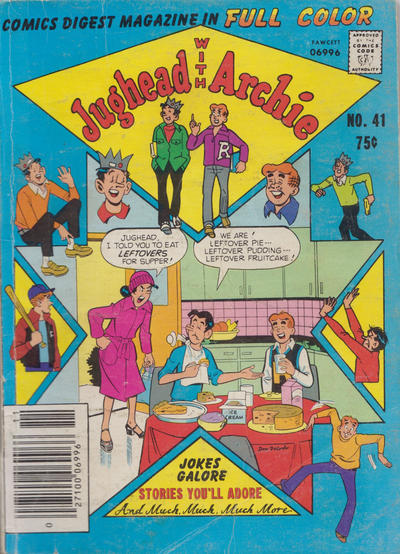

In [24]:
def get_random_sample_of_covers(df: DataFrame, character: str, n: int) -> dict:
    """
    Given a DataFrame of covers (TODO: specify that schema) and a character return a
    dict (TODO: specify that schema) of n randomly sampled covers for that character.
    """
    df = df[df["cover_characters_list_aliases"].apply(lambda x: character in x)].reset_index(drop=True)

    s = list(range(0, max(df.index)))
    random.shuffle(s)

    covers: dict = dict()
    for i in s[:n]:
        covers["cover_{}".format(i)] = {}
        covers["cover_{}".format(i)]["synopsis"] = df["synopsis"].iloc[i]
        covers["cover_{}".format(i)]["image_path"] = df["save_to"].iloc[i]
        covers["cover_{}".format(i)]["cover_inks"] = df["cover_inks"].iloc[i]
        covers["cover_{}".format(i)]["cover_colors"] = df["cover_colors"].iloc[i]
        covers["cover_{}".format(i)]["cover_pencils"] = df["cover_pencils_cleaned"].iloc[i]
        covers["cover_{}".format(i)]["characters"] = df["cover_characters_list_aliases"].iloc[i]

    return covers

random_cover = get_random_sample_of_covers(df_non_dupes[df_non_dupes["cover_characters_list_aliases"].notnull()], 
                                                    character="Archie Andrews", 
                                                    n=1)

synopsis = random_cover[list(random_cover.keys())[0]]["synopsis"]
cover_pencils = random_cover[list(random_cover.keys())[0]]["cover_pencils"]
cover_inks = random_cover[list(random_cover.keys())[0]]["cover_inks"]
cover_colors = random_cover[list(random_cover.keys())[0]]["cover_colors"]
characters = random_cover[list(random_cover.keys())[0]]["characters"]


print("Pencils: {}, Colors: {}, Colors: {}".format(cover_pencils, cover_inks, cover_colors), '\n')

print("Characters: {}".format(characters), '\n')
print("Synopsis: {}".format(synopsis), '\n')

image_path = random_cover[list(random_cover.keys())[0]]["image_path"]
im = Image.open("." + image_path)
im

### Impute Sale Year

In [25]:
import datetime

def convert_sale_date(date: str):
    try:
        return datetime.datetime.strptime(date, '%Y-%m-%d').year
    except:
        pass
    try:
        return datetime.datetime.strptime(date, '%Y').year
    except:
        return 0

df_non_dupes["on_sale_year"] = df_non_dupes["on_sale_date"].str.replace("?", "").str.strip().apply(convert_sale_date)

In [ ]:
# load the metadata
df = analyzer.load_metadata('../metadata/covers.jsonl')

In [70]:
need_sale_year_counts = df_non_dupes[df_non_dupes["on_sale_year"] == 0]["series_name"].value_counts()

series_to_query = need_sale_year_counts[need_sale_year_counts > 25][1:]
series_to_query.sum()

27791

In [74]:
need_sale_year = df_non_dupes[df_non_dupes["on_sale_year"] == 0].sort_values(["series_name", "issue_number"])
need_sale_year = need_sale_year[need_sale_year["series_name"].apply(lambda x: x in series_to_query.index)]
need_sale_year["save_to"]

print(len(need_sale_year["save_to"]))
print(len(need_sale_year["save_to"][::5]))

27791
5559


In [76]:
need_sale_year = need_sale_year["save_to"][::5]
print(len(need_sale_year))

5559


In [77]:
from comics_net.webscraper import get_soup

def get_query(image_path):
    """Given a saved image file name, construct a query.
    """
    query = df_non_dupes[
        df_non_dupes["save_to"] == image_path]["save_to"].values[0].split("/")[-1].\
    replace(" ", "%20").\
    replace(":", "%3A").\
    replace("#", "%23").\
    replace("(", "%28").\
    replace(")", "%29").\
    replace(".jpg", "")
    return query.replace("%20Original%20%28%29", "")


def get_series_name(image_path):
    """Given a saved image file name, parse the series name.
    """
    series_name = image_path.split("/")[-1].split(":")[0].strip()
    return series_name
    
    
def get_issue_search_results(query, series_name):
    """Given a query and series name, return the issue search results
    """
    soup = get_soup("https://www.comics.org/searchNew/?q={}".format(query))
    results = soup.find_all("table", {"class": "listing left"})[0].find_all("tr")

    issues = [{x.find("a").text.strip(): x.find("a")["href"]} 
              for x in results 
              if (x.find("a") is not None) and ("/#" not in x.find("a")["href"])]

    return [x for x in issues if list(x.keys())[0].split("(")[0].strip() in series_name]

def get_year_from_search_results_issue(title: str):
    """
    Given an issue title return the issue number from the string.
    """
    series_year = re.search(r"([\d+][\d+][\d+][\d+] +\b(series)\b)", title)
    if series_year is None:
        return np.nan
    else:
        return series_year.group()

In [82]:
import jsonlines


for i in range(len(need_sale_year)):
    image_path = need_sale_year.iloc[i]
    if i > 0:
        print(year)
        
    query = get_query(image_path) # construct query
    series_name = get_series_name(image_path) # series name

    print(i, ":", series_name)
    try:
        issues = get_issue_search_results(query, series_name) # search results
    except:
        issues = []
    try:
        year = get_year_from_search_results_issue(list(issues[0].keys())[0]) # series year
    except:
        year = np.nan

    # save
    with jsonlines.open(
        "../metadata/on_sale_year.jsonl", mode="a"
    ) as writer:
        writer.write({image_path: year})
    clear_output()

In [ ]:
# thingy = df_non_dupes[["series_name", "issue_number", "on_sale_year", "save_to"]].\
#     sort_values(["series_name", "issue_number"]).values

# for i in range(len(thingy)-2):
#     t = thingy[0+i:2+i]
#     a = t[0]
#     b = t[1]
#     if a[0] == b[0]:
#         if (a[2] != 0) & (b[2] == 0):
#             thingy[1+i][2] = a[2]            

# thingy = pd.DataFrame(thingy, columns=["series_name", "issue_number", "on_sale_year", "save_to"])

# thingy_2 = pd.merge(thingy, date_interpolation, on="series_name", how="left")
# thingy_2.loc[(thingy_2["on_sale_year"] == 0) & (thingy_2["max"] != 0), "on_sale_year"] = thingy_2.loc[(thingy_2["on_sale_year"] == 0) & (thingy_2["max"] != 0), "max"]

# thingy_2 = thingy_2[thingy_2["on_sale_year"] != 0][["series_name", "issue_number", "on_sale_year", "save_to"]]
# thingy_2.columns = ["series_name", "issue_number", "on_sale_year_interpolated", "save_to"]

# thingy_2["issue_number"] = pd.to_numeric(thingy_2["issue_number"], errors='coerce')

# thingy_2 = thingy_2.dropna()


In [ ]:
df_non_dupes = pd.merge(df_non_dupes, thingy_2, on=["save_to"], how="left")

df_sale_year = df_non_dupes[df_non_dupes["on_sale_year_interpolated"].notnull()]

df_sale_year.loc[:, "on_sale_year_interpolated"] = df_sale_year["on_sale_year_interpolated"].astype(int)
df_sale_year["on_sale_year_interpolated"].value_counts()[:25]

In [ ]:
eras = {"Golden Age": np.arange(1938, 1956, 1),
        "Silver Age": np.arange(1956, 1970, 1),
        "Bronze Age": np.arange(1970, 1985, 1),
        "Modern 90's": np.arange(1985, 2000, 1),
        "Modern 00's": np.arange(2000, 2010, 1),
        "Modern Age": np.arange(2010, 2020, 1)}

# eras = {"Golden Age": np.arange(1938, 1956, 1),
#         "Silver Age": np.arange(1956, 1970, 1),
#         "Bronze Age": np.arange(1970, 1985, 1),
#         "Modern Age": np.arange(1985, 2020, 1)}

def get_era(year):
    for era in eras:
        if year in eras[era]:
            return era
        
df_sale_year.loc[:, "on_sale_year_era"] = df_sale_year["on_sale_year_interpolated"].apply(get_era)

In [ ]:
df_sale_year["on_sale_year_era"].value_counts()

In [ ]:
genre_by_series = df_sale_year.groupby(["series_name_x","cover_genre"]).\
                    apply(len).\
                    reset_index().\
                    dropna().\
                    groupby(["series_name_x"]).apply(max).\
                    reset_index(drop=True).\
                    drop(0, axis=1)

genres = pd.merge(df_sale_year, genre_by_series, on="series_name_x", how="left")[["cover_genre_x", "cover_genre_y"]].values
genres = [x[0] if x[0] is not np.nan else x[1] for x in genres]

df_sale_year.loc[:, "cover_genre_clean"] = genres
df_sale_year.loc[:, "cover_genre_clean"] = df_sale_year["cover_genre_clean"].fillna("NaN")

df_sale_year.loc[:, "cover_genre_clean"] = df_sale_year["cover_genre_clean"].apply(lambda x: x.strip()).\
    apply(lambda x: x.lstrip(" ")).\
    apply(lambda x: x.replace("super-héroes (superhero)", "superhero")).\
    apply(lambda x: x.replace("anthropomorphic-funny animals", "animals")).\
    apply(lambda x: x.replace('fantasy-supernatural-supernatural', 'fantasy-supernatural'))

genres = analyzer.flatten(df_sale_year["cover_genre_clean"].apply(lambda x: analyzer.convert_characters_to_list(x)))
genres = pd.Series(genres)[pd.Series(genres) != "NaN"].value_counts()[:20]

df_sale_year.loc[:, "cover_genre_list"] = df_sale_year["cover_genre_clean"].apply(lambda x: analyzer.convert_characters_to_list(x))


In [ ]:
genres.sort_values()

In [ ]:
def get_genre(list_of_genres):
    for genre in genres.sort_values().index:
        if genre not in list_of_genres:
            continue
        elif genre in list_of_genres:
            return genre
    return "other"
        
df_sale_year.loc[:, "cover_genre_final"] = df_sale_year["cover_genre_list"].apply(get_genre)

In [ ]:
df_sale_year.loc[:, "label"] = df_sale_year["on_sale_year_era"] + " - " + df_sale_year["cover_genre_final"]

In [ ]:
print("{} images over {} categories".format(df_sale_year["label"].value_counts().sum(), len(df_sale_year["label"].value_counts())))

df_sale_year["label"].value_counts()

In [ ]:
final = df_sale_year["label"].value_counts()[df_sale_year["label"].value_counts() > 500]

print("{} images over {} categories".format(final.sum(), len(final)))
final

In [ ]:
label = "Modern Age - superhero"

def get_random_sample_of_covers(df: DataFrame, label: str, n: int) -> dict:
    """
    Given a DataFrame of covers (TODO: specify that schema) and a character return a
    dict (TODO: specify that schema) of n randomly sampled covers for that character.
    """
    df = df[df["label"] == label].reset_index(drop=True)

    s = list(range(0, max(df.index)))
    random.shuffle(s)

    covers: dict = dict()
    for i in s[:n]:
        covers["cover_{}".format(i)] = {}
        covers["cover_{}".format(i)]["synopsis"] = df["synopsis"].iloc[i]
        covers["cover_{}".format(i)]["image_path"] = df["save_to"].iloc[i]
        covers["cover_{}".format(i)]["on_sale_year_interpolated"] = df["on_sale_year_interpolated"].iloc[i]
        covers["cover_{}".format(i)]["cover_genre_list"] = df["cover_genre_list"].iloc[i]
        covers["cover_{}".format(i)]["issue_indicia_publisher"] = df["issue_indicia_publisher"].iloc[i]
        covers["cover_{}".format(i)]["characters"] = df["cover_characters_list_aliases"].iloc[i]

    return covers

random_cover = get_random_sample_of_covers(df_sale_year, 
                                           label, 
                                           n=1)

image_path = random_cover[list(random_cover.keys())[0]]["image_path"]
issue_indicia_publisher = random_cover[list(random_cover.keys())[0]]["issue_indicia_publisher"]
on_sale_year_interpolated = random_cover[list(random_cover.keys())[0]]["on_sale_year_interpolated"]
cover_genre_list = random_cover[list(random_cover.keys())[0]]["cover_genre_list"]


print("Publisher: {}".format(issue_indicia_publisher))
print("On Sale Year: {}".format(on_sale_year_interpolated))
print("Genre List: {}".format(cover_genre_list))
print(image_path)

image_path = random_cover[list(random_cover.keys())[0]]["image_path"]
im = Image.open("." + image_path)
im

In [ ]:
# import requests

# filePath = "." + image_path
# searchUrl = 'http://www.google.hr/searchbyimage/upload'
# multipart = {'encoded_image': (filePath, open(filePath, 'rb')), 'image_content': ''}
# response = requests.post(searchUrl, files=multipart, allow_redirects=False)
# fetchUrl = response.headers['Location']
# print(fetchUrl)

# from urllib.request import Request, urlopen

# headers={"user-agent": 
#          "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/53.0.2785.143 Safari/537.36"}
 
# req = Request(fetchUrl, headers=headers)
# webpage = urlopen(req)
# soup = BeautifulSoup(webpage, 'html.parser')

# search_results = soup.find_all("div", {"class": "g"})

# links = []
# for result in search_results:
#     links.append(result.find_all("a")[0]["href"])
    
# links

In [ ]:
# df_non_dupes[
#     df_non_dupes["save_to"] == image_path]["image_url"].values


### Label Images w/ Character Bounding Boxes

In [ ]:
df_character_labels = df_non_dupes[df_non_dupes["cover_characters_list_aliases"].notnull()]
idx = ["Batman [Bruce Wayne]" in x for x in df_character_labels["cover_characters_list_aliases"]]

to_annotate = df_character_labels[idx].sort_values(by="save_to", ascending=True)

character_list = to_annotate[["cover_characters_list_aliases", "save_to"]].dropna()

characters_text = list(to_annotate["cover_characters_list_aliases"].values)

coverfns = list(to_annotate["save_to"].values)
coverfns = [x.split("/")[-1] for x in coverfns]

characters = pd.Series(
    analyzer.flatten(to_annotate["cover_characters_list_aliases"].values)).value_counts()

classes = list(characters[characters > 100].index)
classes

In [ ]:
# len(characters_text), len(coverfns)

In [ ]:
from jupyter_innotater import *
import numpy as np, os

repeats = len(classes)

# instantiate empty per-photo data objects
targets_exclude = np.zeros((len(coverfns), 1), dtype='int') # binary flag to indicate exclusions
targets_classes = np.zeros((len(coverfns), len(classes)), dtype='int') # integer encoding for each label class
targets_bboxes = np.zeros((len(coverfns), repeats, len(classes)), dtype='int') # (x,y,w,h) for each animal

Innotater(
    [
        ImageInnotation(coverfns, path='../covers/', width=400, height=600), # Display the image itself
        TextInnotation(characters_text, multiline=True) # Display the image filename
    ],
    [
        BinaryClassInnotation(targets_classes, name='Exclude'), # Checkbox
        RepeatInnotation(
            (BoundingBoxInnotation, targets_bboxes), # Individual character bounding box
            (MultiClassInnotation , targets_classes,
                {'name':'Character', 'classes': classes, 'dropdown':True}), # Per-character label dropdown
            max_repeats=repeats, min_repeats=repeats
        )
    ]
)

In [ ]:
labels = pd.DataFrame([[x, *list(zip(z, y))] for x, y, z in list(zip(coverfns, targets_bboxes, targets_classes))])
labels

In [ ]:
# for i in range(1, 17):
#     labels[i] = labels[i].apply(lambda x: {x[0]: dict(zip(["x", "y", "w", "h"], x[1]))})
    
# labels.columns = ["title", "label_1", "label_2", "label_3", "label_4"]
# labels

In [ ]:
# df.to_csv('./bounding_boxes_detective_comics_71.csv', index=False)